<a href="https://colab.research.google.com/github/4myLab/codestates/blob/main/20220720.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install shap
!pip install category_encoders
# !pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.4 MB/s 


In [3]:
%%capture

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [7]:
import pandas as pd

df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/lending_club/lending_club_sampled.csv')
df['issue_d'] = pd.to_datetime(df['issue_d'], infer_datetime_format=True)

df = df.set_index('issue_d').sort_index()

df['interest_rate'] = df['int_rate'].astype(float)
df['monthly_debts'] = df['annual_inc'] / 12 * df['dti'] / 100

columns = ['annual_inc', # 연수입
           'fico_range_high', # 신용점수 
           'funded_amnt', # 대출
           'title', # 대출 목적
           'monthly_debts', # 월간 부채
           'interest_rate'] # 이자율

df = df[columns]
df = df.dropna()

test = df[-10000:]
val = df[-20000:-10000]
train = df[:-20000]

In [8]:
df.columns

Index(['annual_inc', 'fico_range_high', 'funded_amnt', 'title',
       'monthly_debts', 'interest_rate'],
      dtype='object')

In [9]:
test.shape, val.shape, train.shape


((10000, 6), (10000, 6), (76408, 6))

In [10]:
target = 'interest_rate' 
features = df.columns.drop('interest_rate')

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


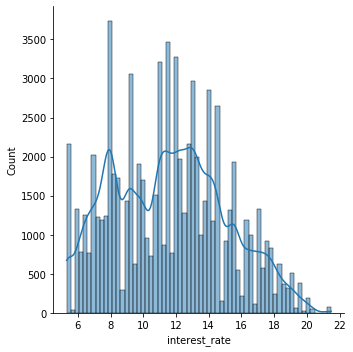

In [11]:
%matplotlib inline
import seaborn as sns
sns.displot(y_train, kde=True);

In [14]:
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R^2', linear.score(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


R^2 0.17585064958164265


In [15]:
coefficients = linear.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

annual_inc        -0.000005
fico_range_high   -0.052805
funded_amnt        0.000021
title              1.007214
monthly_debts      0.000019
dtype: float64

In [18]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror',
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), (X_val_encoded, y_val)]
boosting.fit(
    X_train_encoded, y_train,
    eval_set=eval_set,
    early_stopping_rounds=50
)

[0]	validation_0-rmse:9.46177	validation_1-rmse:10.185
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:7.77956	validation_1-rmse:8.52515
[2]	validation_0-rmse:6.4691	validation_1-rmse:7.23695
[3]	validation_0-rmse:5.46844	validation_1-rmse:6.24501
[4]	validation_0-rmse:4.71471	validation_1-rmse:5.48482
[5]	validation_0-rmse:4.15469	validation_1-rmse:4.90874
[6]	validation_0-rmse:3.74825	validation_1-rmse:4.49643
[7]	validation_0-rmse:3.45963	validation_1-rmse:4.18831
[8]	validation_0-rmse:3.25941	validation_1-rmse:3.96925
[9]	validation_0-rmse:3.12104	validation_1-rmse:3.79854
[10]	validation_0-rmse:3.02593	validation_1-rmse:3.68583
[11]	validation_0-rmse:2.95607	validation_1-rmse:3.5969
[12]	validation_0-rmse:2.911	validation_1-rmse:3.53576
[13]	validation_0-rmse:2.87811	validation_1-rmse:3.48956
[14]	validation_0-rmse:2.85599	validation_1-rmse:3.45471
[

XGBRegressor(learning_rate=0.2, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror')

In [19]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))

R^2 0.228134736099475


In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

In [22]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'annual_inc'

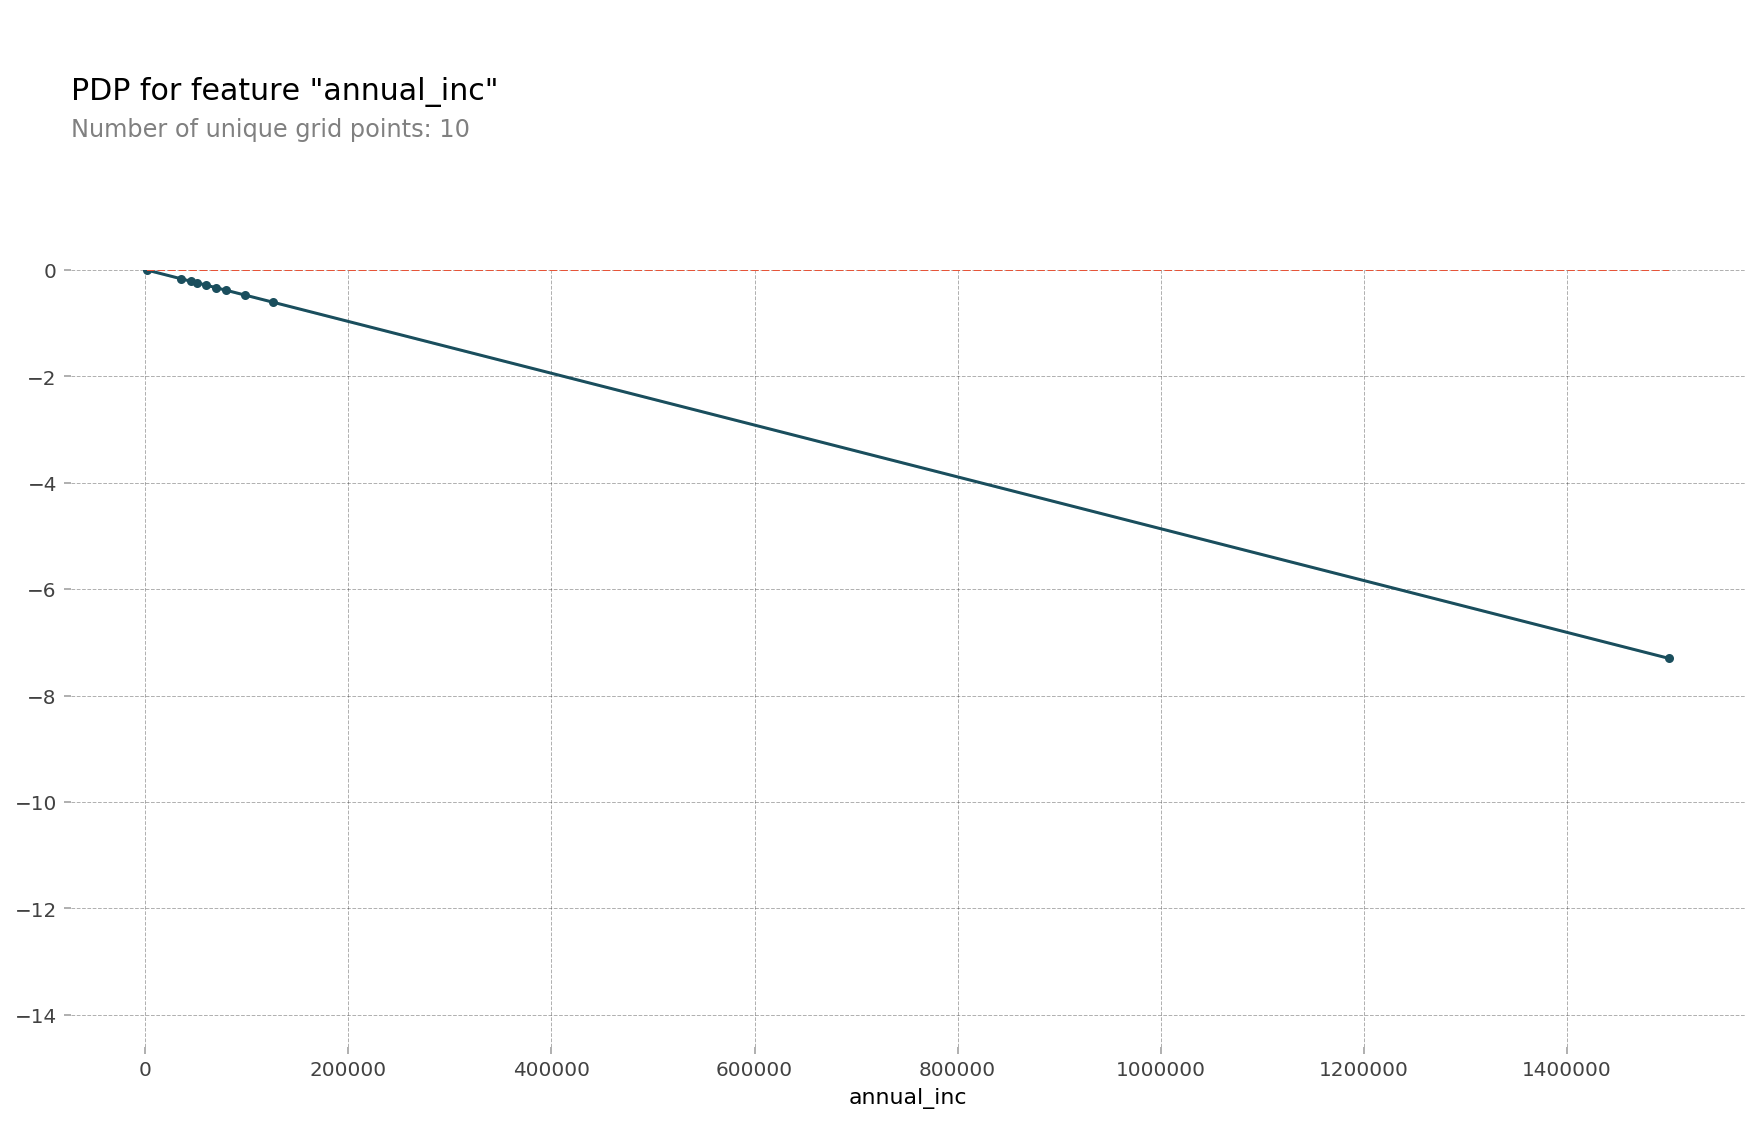

In [25]:
isolated = pdp_isolate(
    model = linear,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature,
    grid_type='percentile',
    num_grid_points = 10
)

pdp_plot(isolated, feature_name=feature);

(<Figure size 2160x1368 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f80b34d3850>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f80b34e0950>})

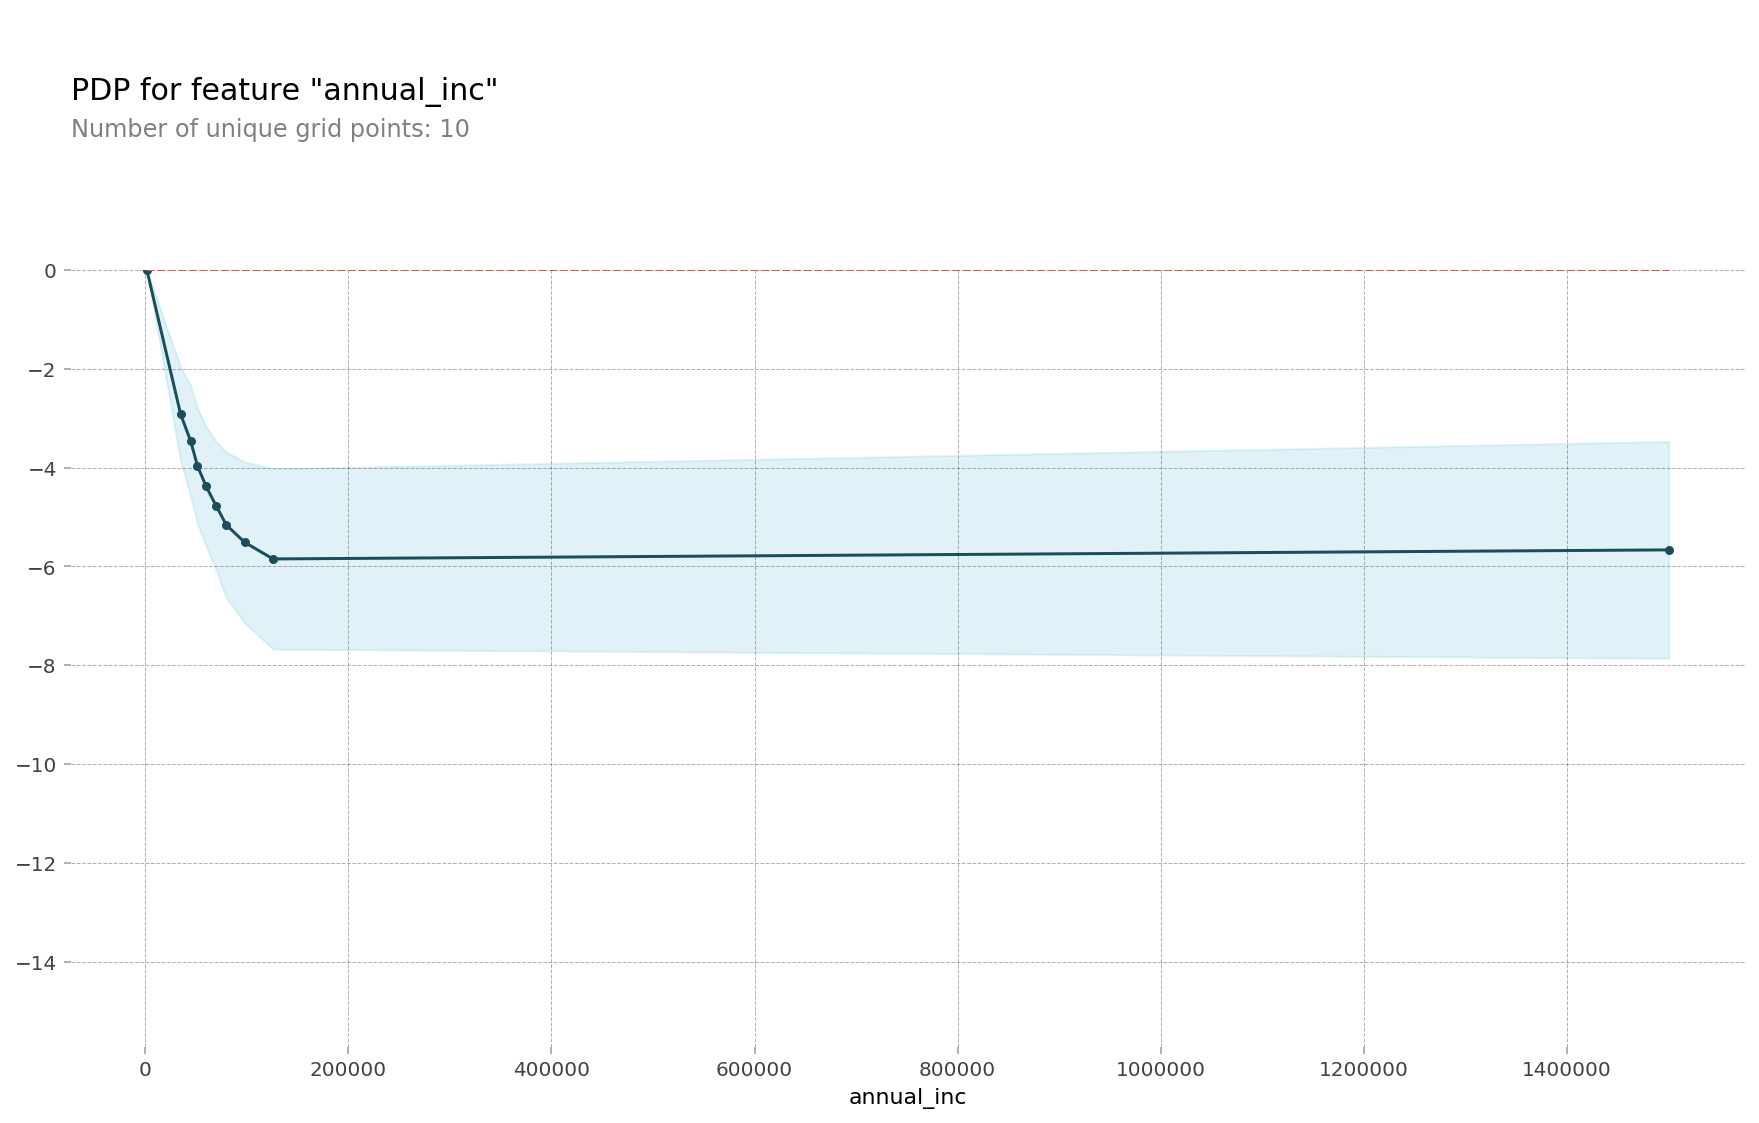

In [26]:
isolated = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature
)
pdp_plot(isolated, feature_name=feature)

(20000, 150000)

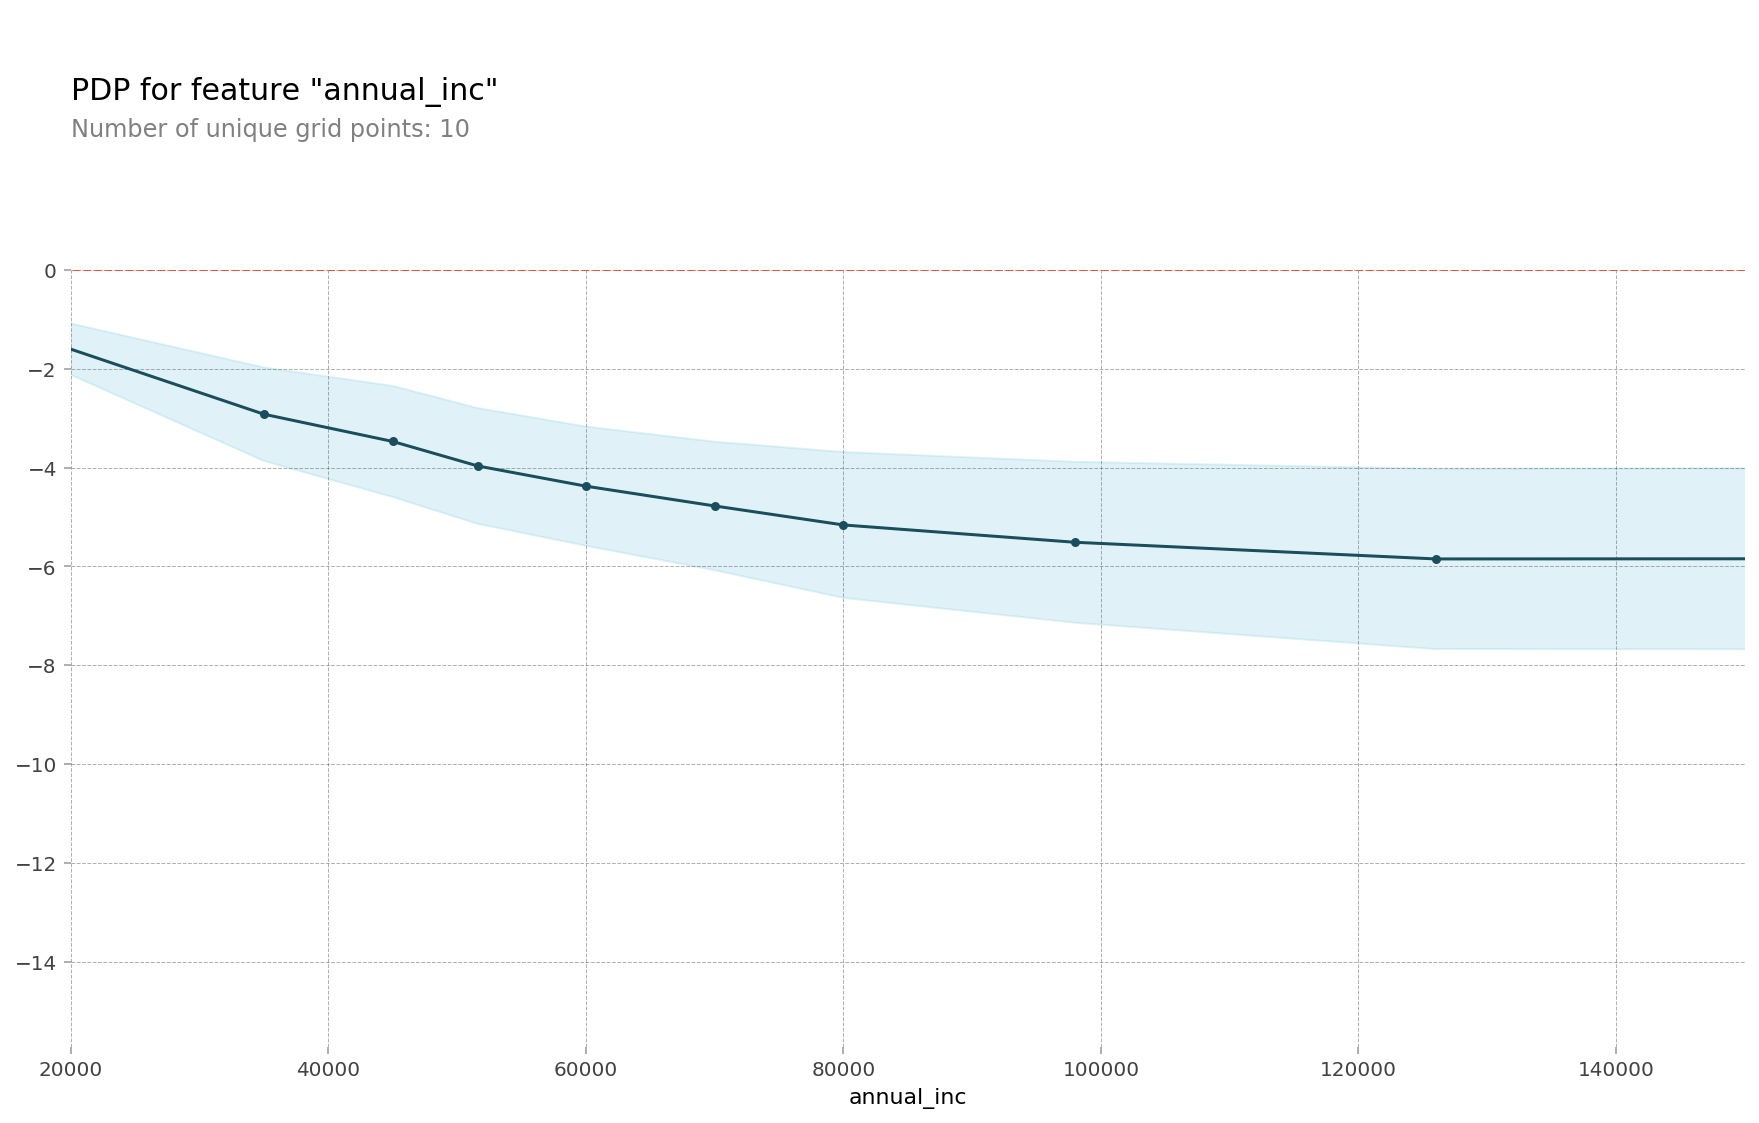

In [27]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((20000,150000))

(20000, 150000)

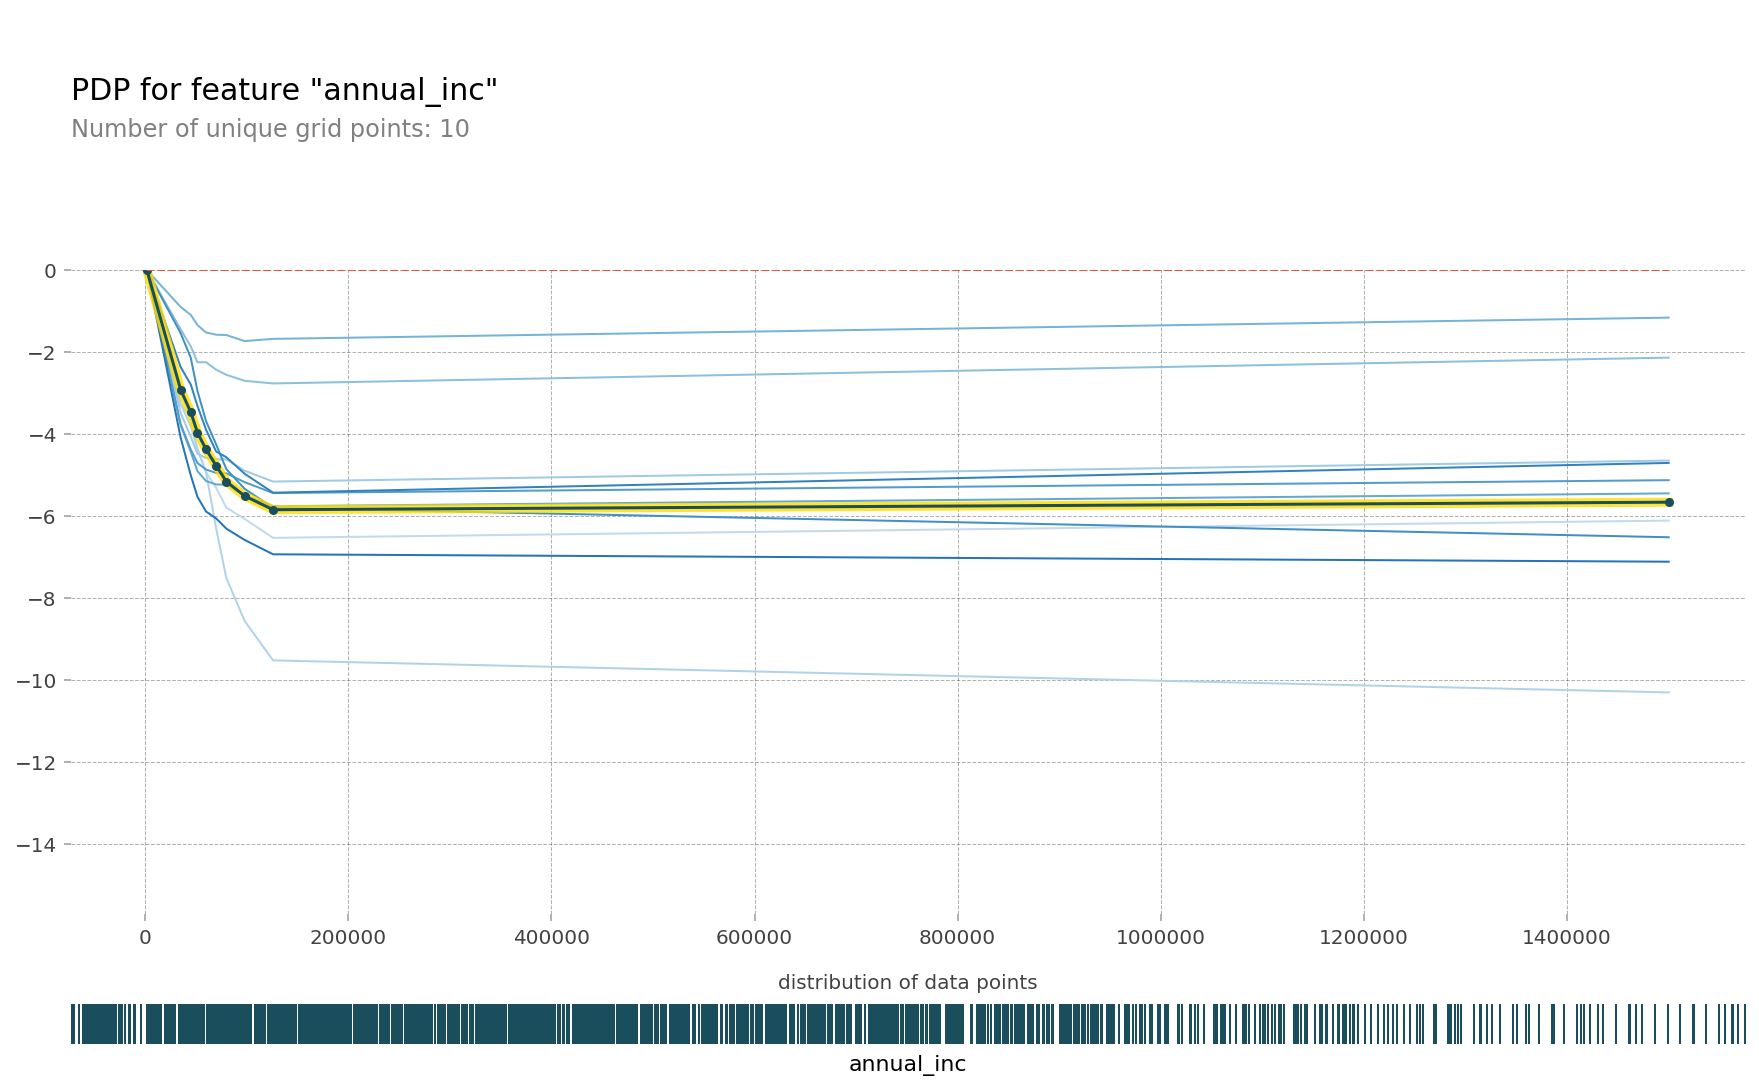

In [28]:
pdp_plot(isolated,
         feature_name=feature,
         plot_lines=True,
         frac_to_plot=0.001,
         plot_pts_dist=True)

plt.xlim(20000,150000)

In [29]:
X_val_encoded['annual_inc'].value_counts()

60000.0    391
50000.0    388
65000.0    290
70000.0    282
40000.0    271
          ... 
16884.0      1
74400.0      1
36948.0      1
48281.0      1
50120.0      1
Name: annual_inc, Length: 1386, dtype: int64

In [34]:
isolated = pdp_isolate(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature,
    num_grid_points=100
)

print('예측수: ',len(X_val) * 100)

예측수:  1000000


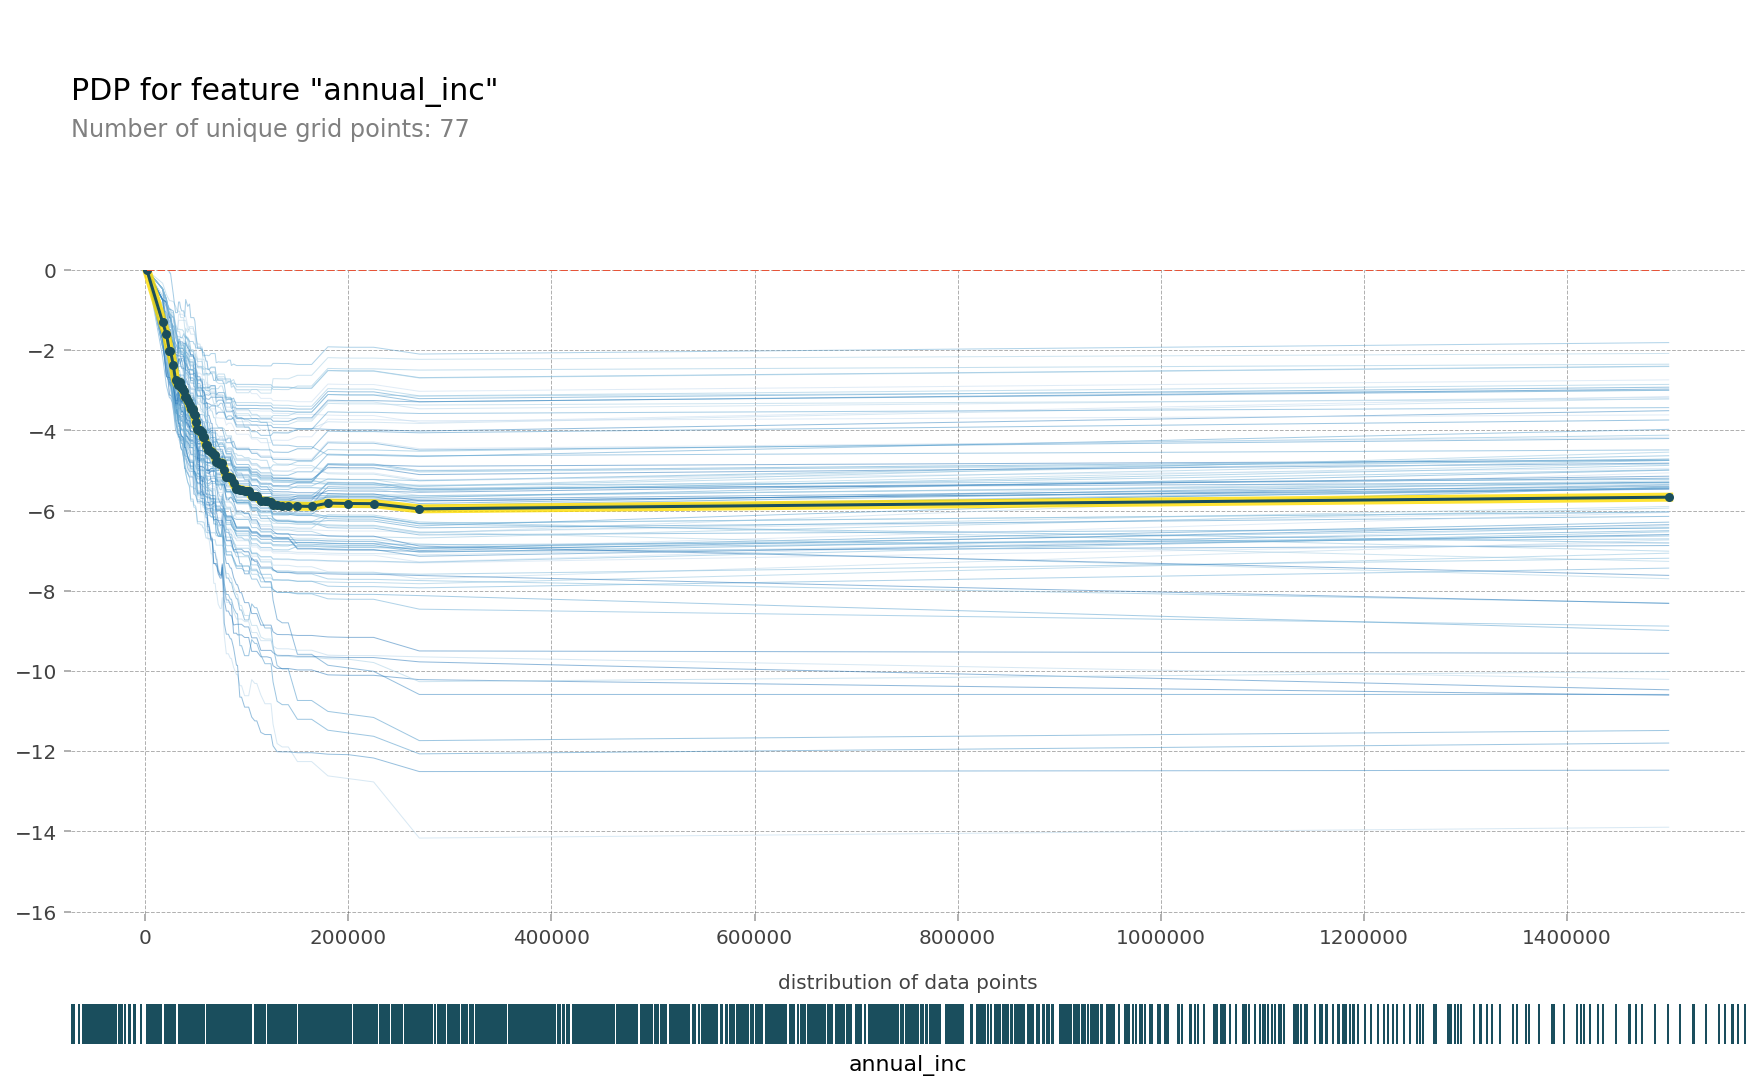

In [35]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01 # ICE curves는 100개
         , plot_pts_dist=True )

plt.xlim(20000,150000);

In [36]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

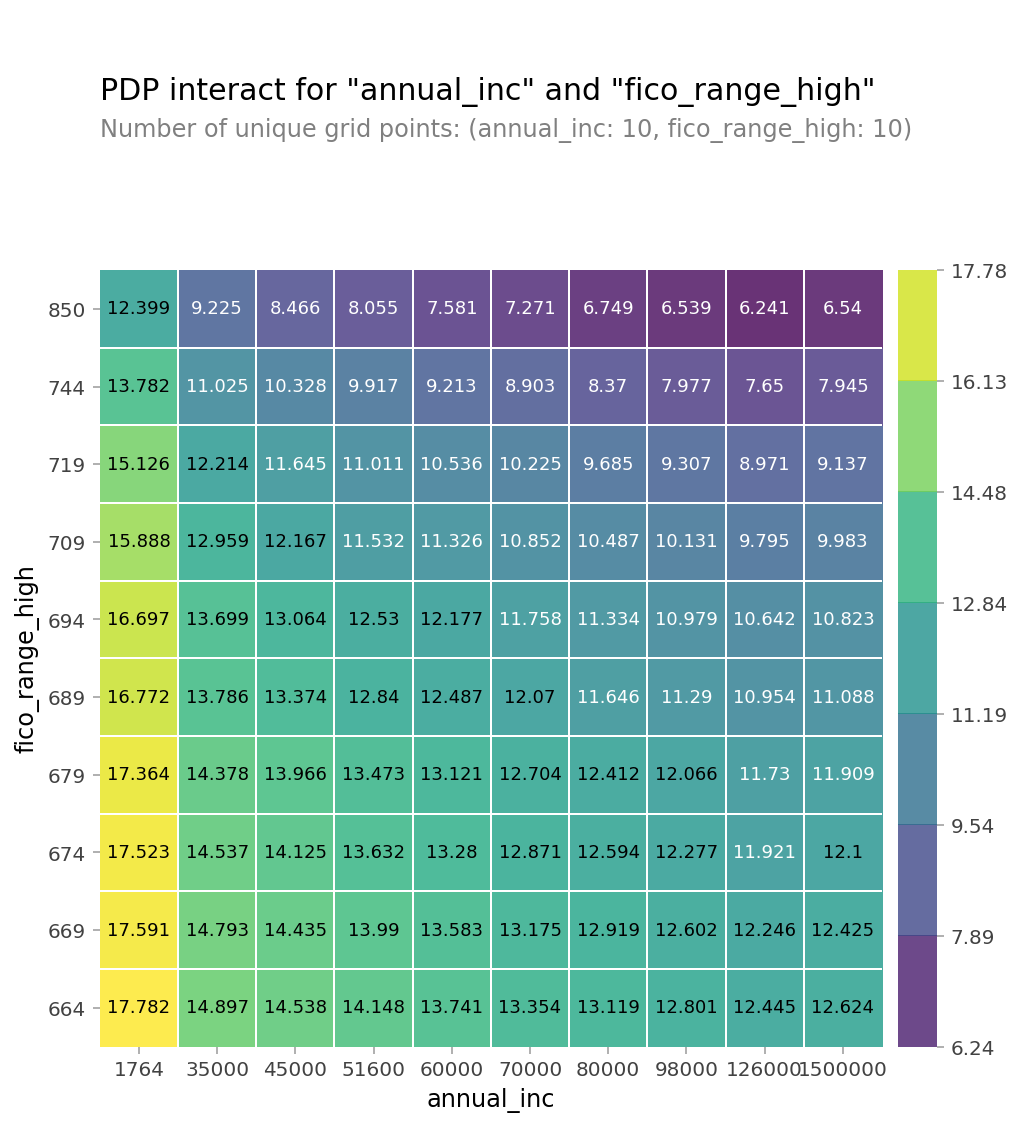

In [37]:
features = ['annual_inc', 'fico_range_high']

interaction = pdp_interact(
    model=boosting,
    dataset=X_val_encoded,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [38]:
features

['annual_inc', 'fico_range_high']

In [41]:
interaction.pdp

,annual_inc,fico_range_high,preds
0,1764.0,664.0,17.782249
1,1764.0,669.0,17.590759
2,1764.0,674.0,17.522755
3,1764.0,679.0,17.364098
4,1764.0,689.0,16.771812
...,...,...,...
95,1500000.0,694.0,10.823479
96,1500000.0,709.0,9.983106
97,1500000.0,719.0,9.136848
98,1500000.0,744.0,7.945443


In [42]:
type(interaction.pdp)

pandas.core.frame.DataFrame

In [49]:
pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)[::-1]

In [50]:
pdp

annual_inc,1764.0,35000.0,45000.0,51600.0,60000.0,70000.0,80000.0,98000.0,126000.0,1500000.0
fico_range_high,,,,,,,,,,
850.0,12.399156,9.224714,8.466422,8.055144,7.581292,7.270982,6.748734,6.539249,6.240531,6.539561
744.0,13.782274,11.024554,10.328446,9.917168,9.212922,8.902613,8.369845,7.976737,7.650156,7.945443
719.0,15.125908,12.214366,11.644770,11.010532,10.535609,10.225301,9.684917,9.306730,8.970580,9.136848
709.0,15.887759,12.959022,12.166584,11.532347,11.326099,10.852192,10.487182,10.131365,9.795216,9.983106
694.0,16.696865,13.698924,13.063718,12.529786,12.177488,11.758325,11.334335,10.978518,10.642368,10.823479
689.0,16.771812,13.786046,13.373682,12.839750,12.487453,12.070300,11.646310,11.290494,10.954344,11.088095
679.0,17.364098,14.378331,13.965967,13.473142,13.120844,12.703691,12.412333,12.066160,11.730010,11.908946
674.0,17.522755,14.536989,14.124625,13.631800,13.279501,12.871307,12.593920,12.276810,11.920773,12.099708
669.0,17.590759,14.793449,14.435345,13.990102,13.583004,13.174810,12.919426,12.602316,12.246279,12.425215


In [51]:
pdp = pdp.drop(columns=[1764.0, 1500000.0])

In [52]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()


In [53]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

df = sns.load_dataset('titanic')
df['age'] = df['age'].fillna(df['age'].median())
df = df.drop(columns='deck') # NaN 77%
df = df.dropna()

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

In [56]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe.fit(X, y);

In [57]:
encoder = pipe.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X)
rf = pipe.named_steps['randomforestclassifier']

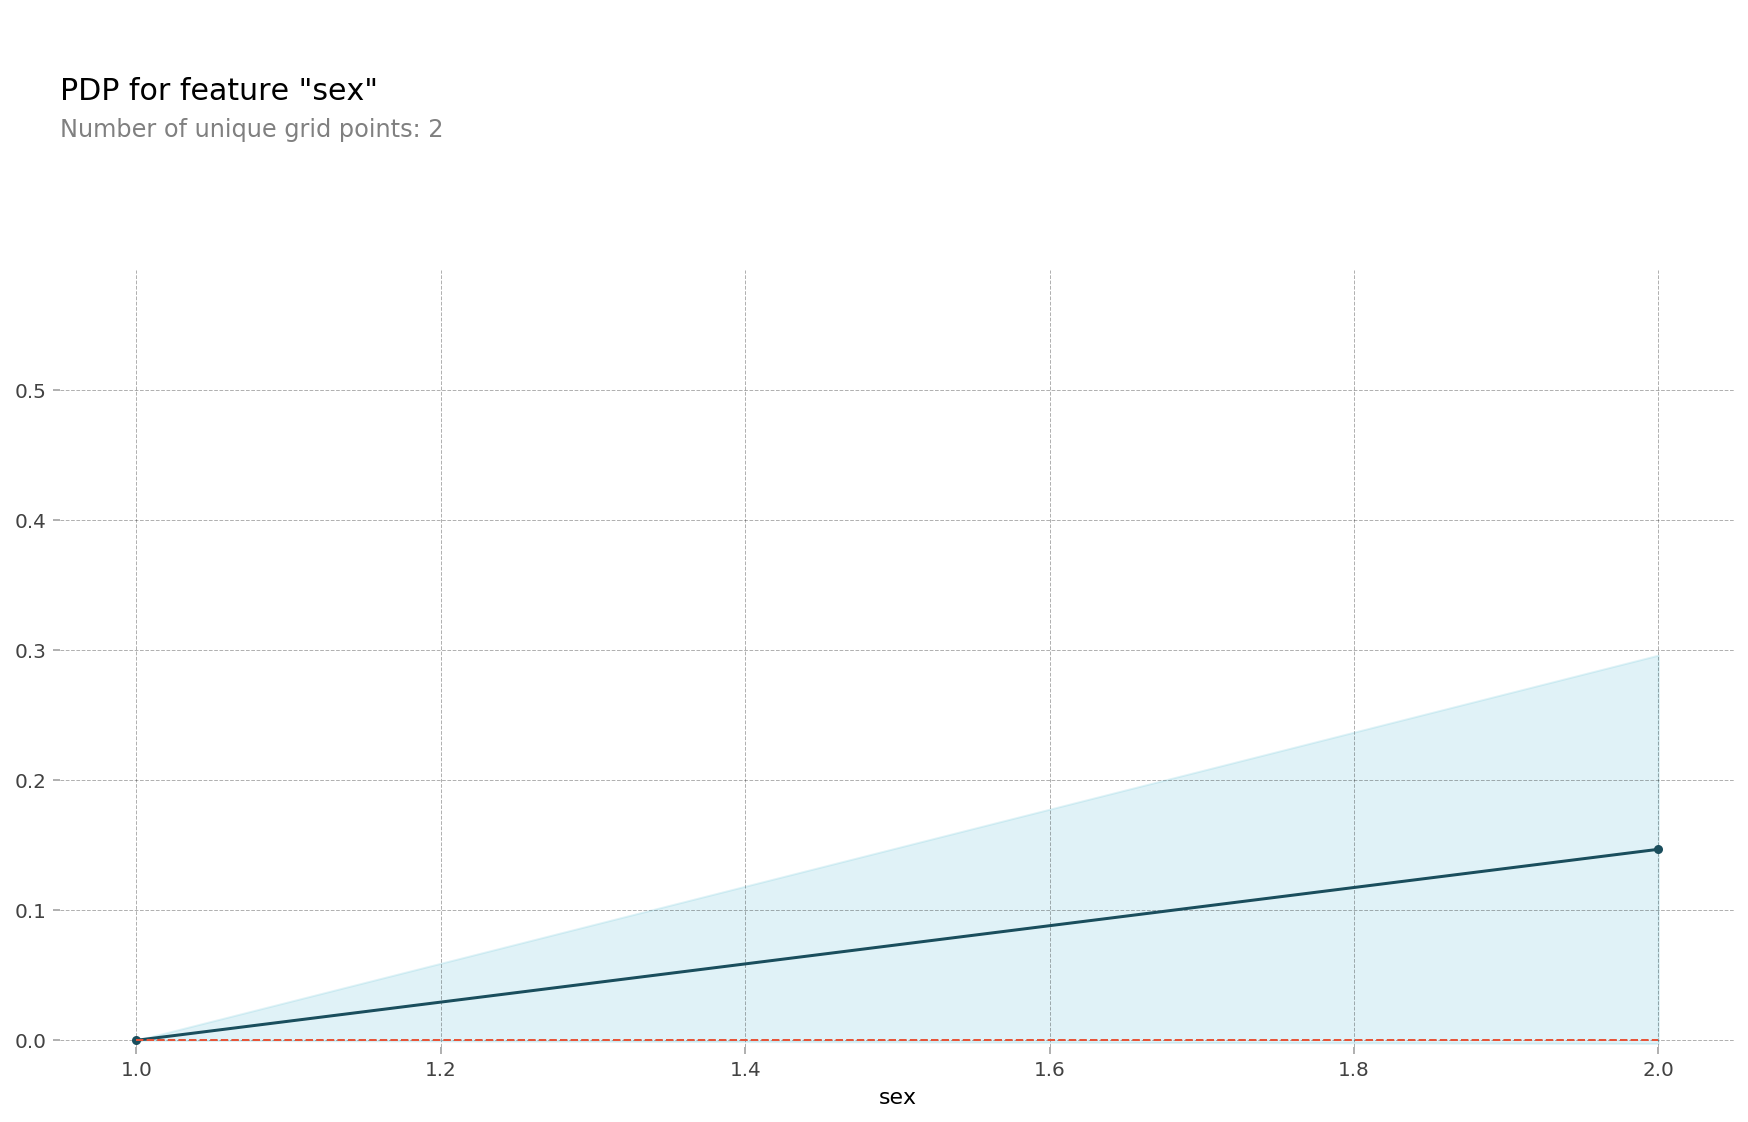

In [58]:
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); # 인코딩된 sex 값을 확인할 수 있습니다

In [59]:
encoder.mapping

[{'col': 'sex', 'data_type': dtype('O'), 'mapping': male      1
  female    2
  NaN      -2
  dtype: int64},
 {'col': 'embarked', 'data_type': dtype('O'), 'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64},
 {'col': 'class',
  'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False),
  'mapping': Third     1
  First     2
  Second    3
  NaN      -2
  dtype: int64},
 {'col': 'who', 'data_type': dtype('O'), 'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64},
 {'col': 'embark_town', 'data_type': dtype('O'), 'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64}]

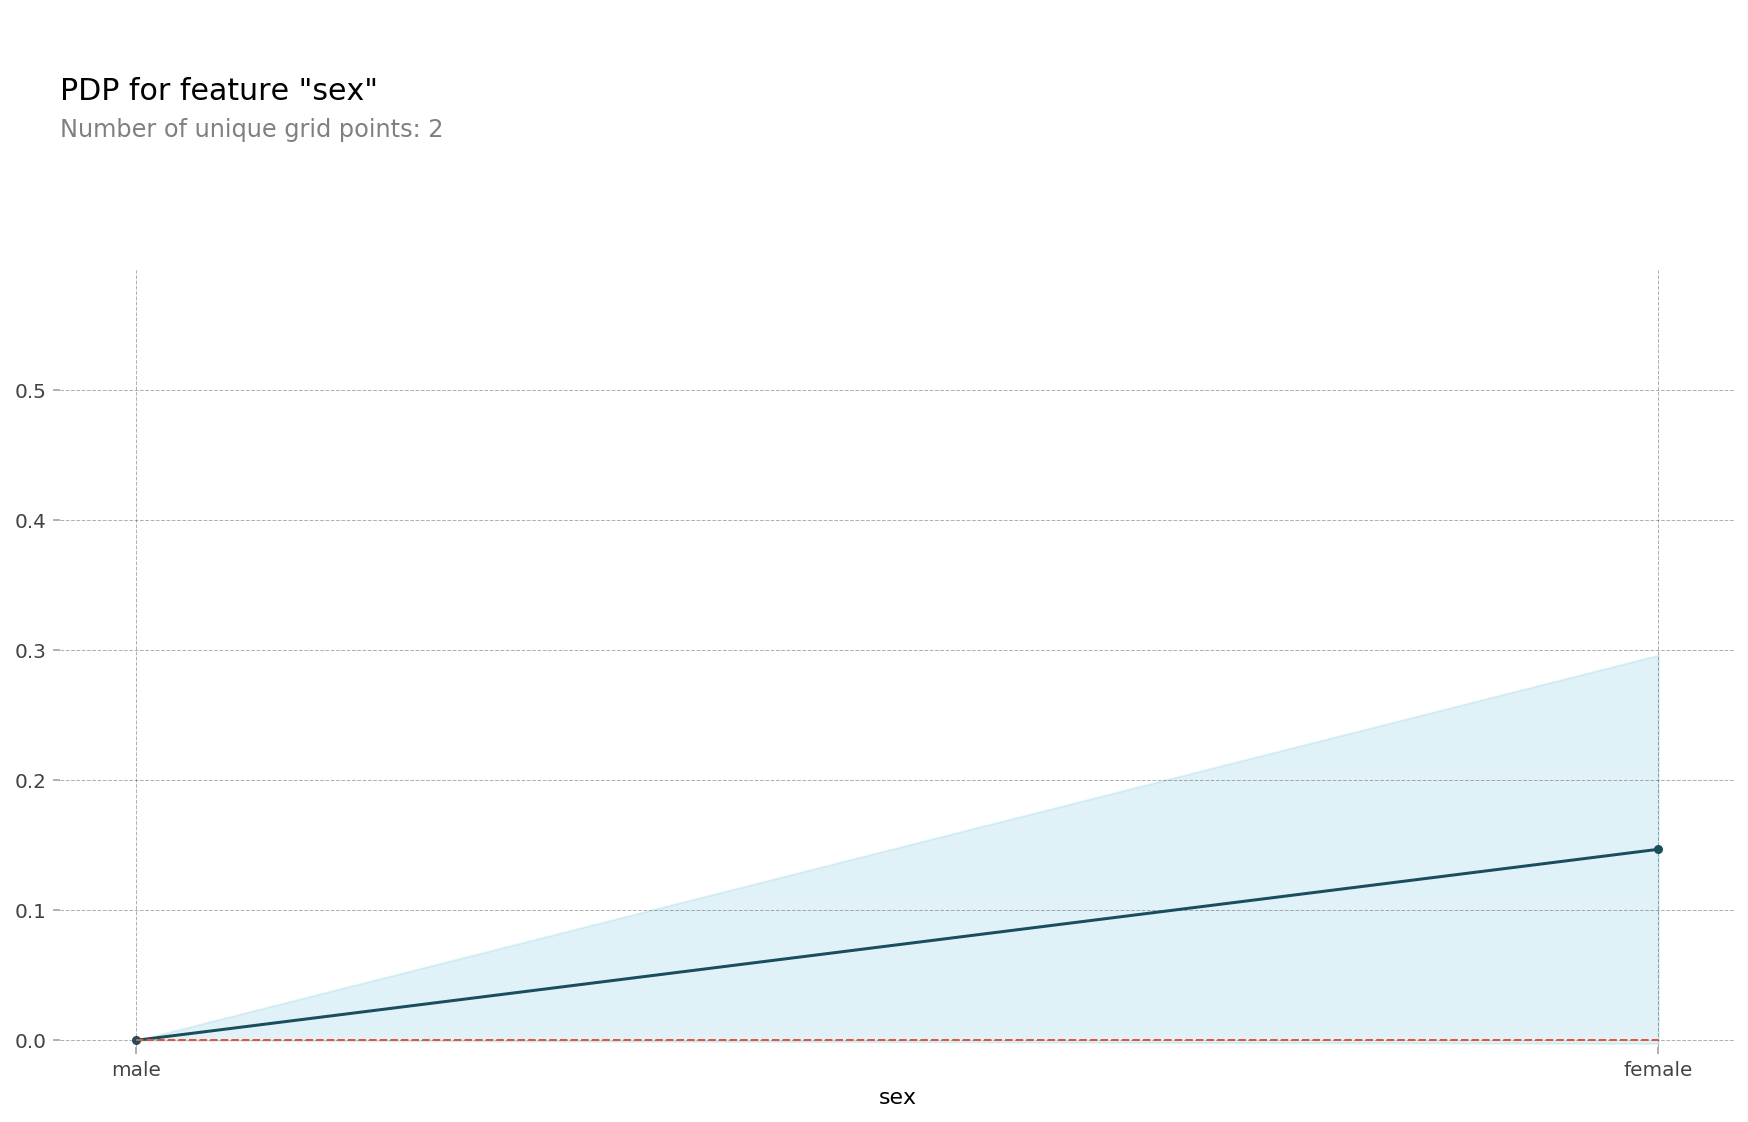

In [62]:
pdp.pdp_plot(pdp_dist, feature)
plt.xticks([1, 2], ['male', 'female',]);


In [63]:
feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

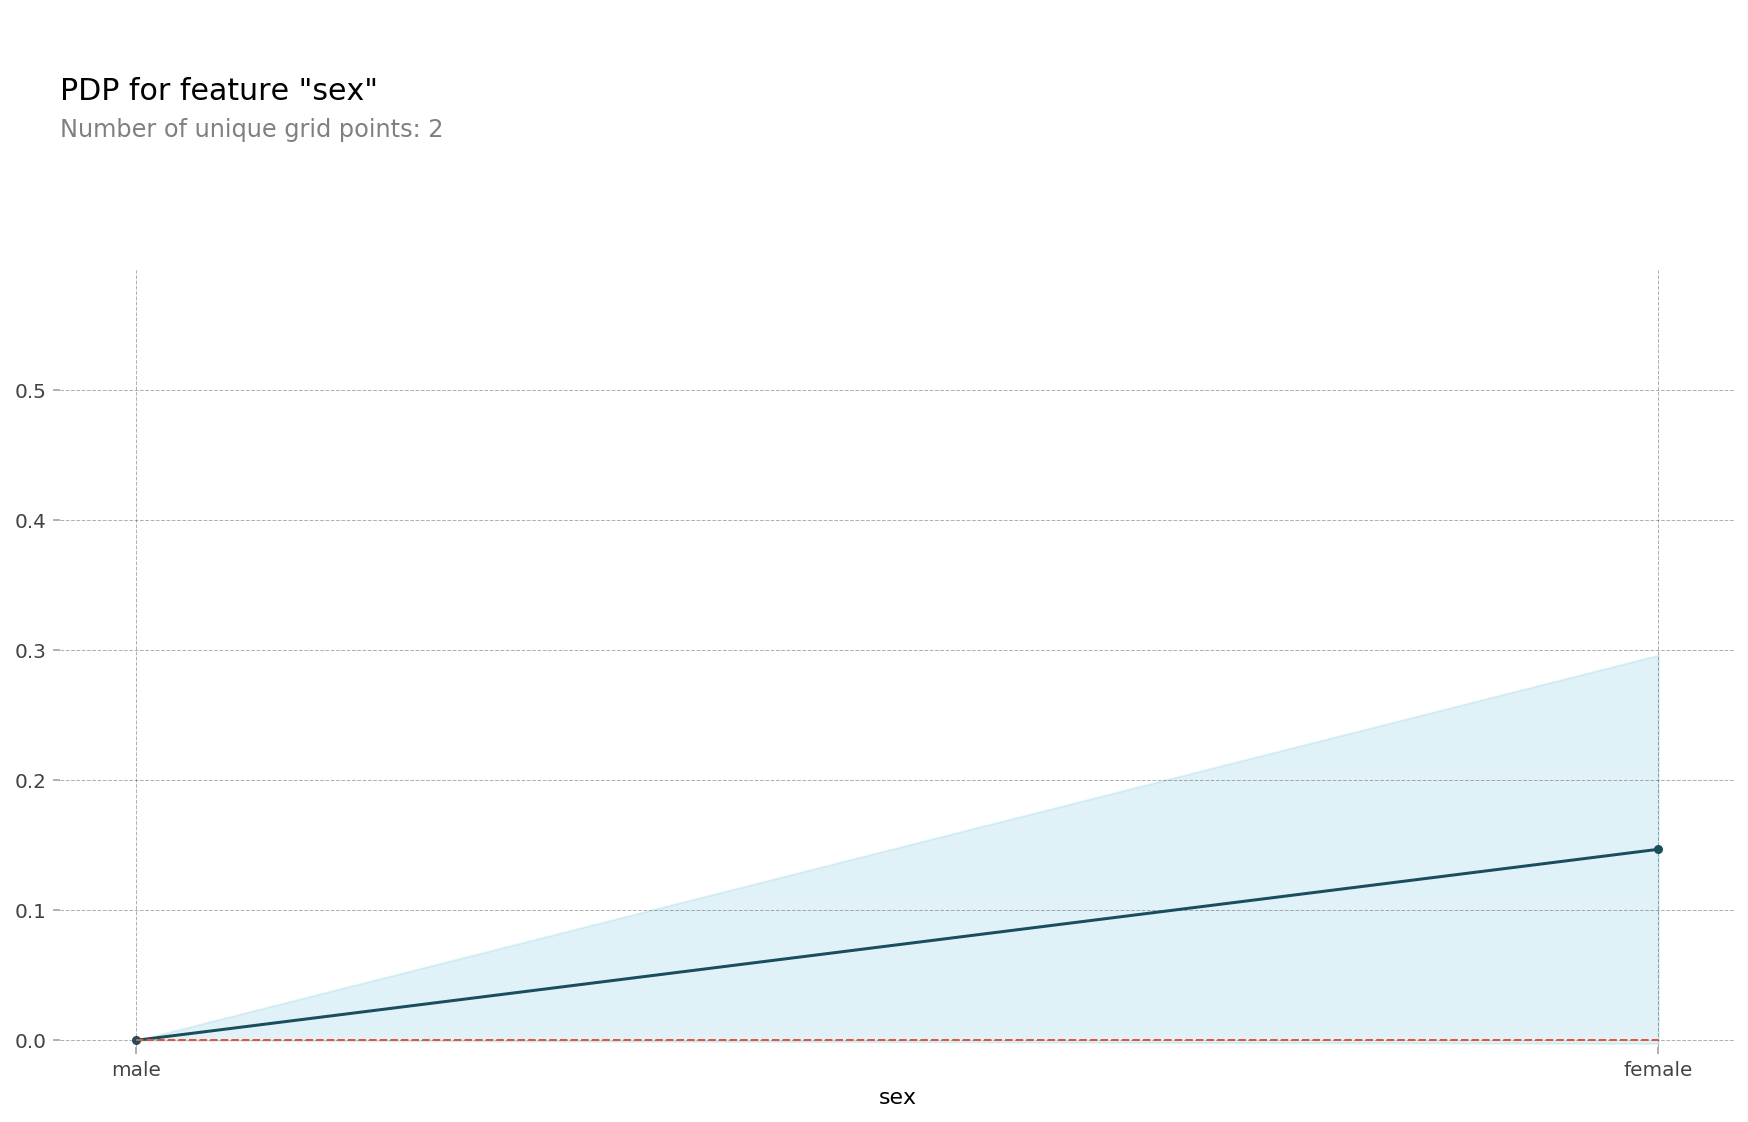

In [64]:
pdp.pdp_plot(pdp_dist, feature)

plt.xticks(category_codes, category_names);


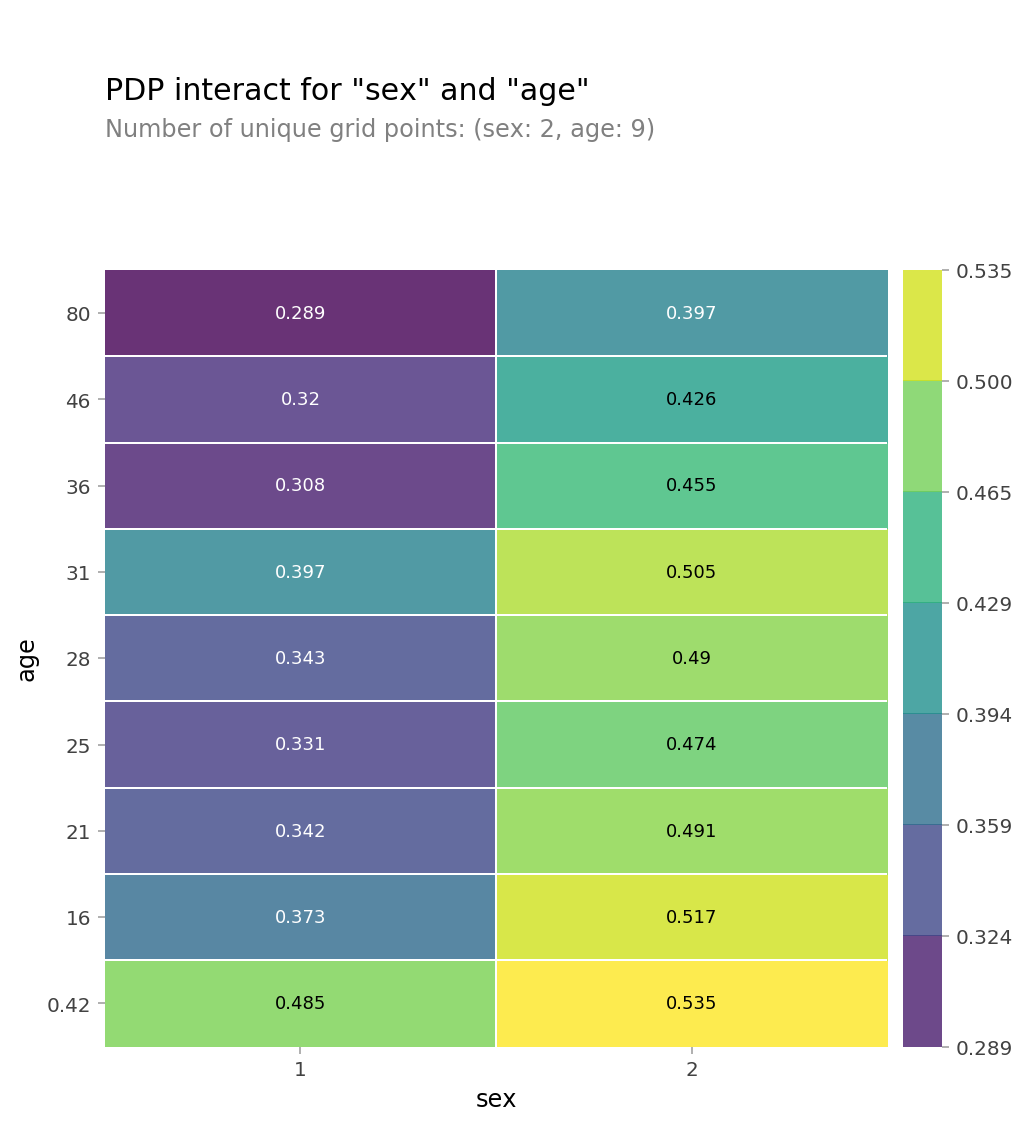

In [65]:
features = ['sex', 'age']

interaction = pdp_interact(
    model=rf, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

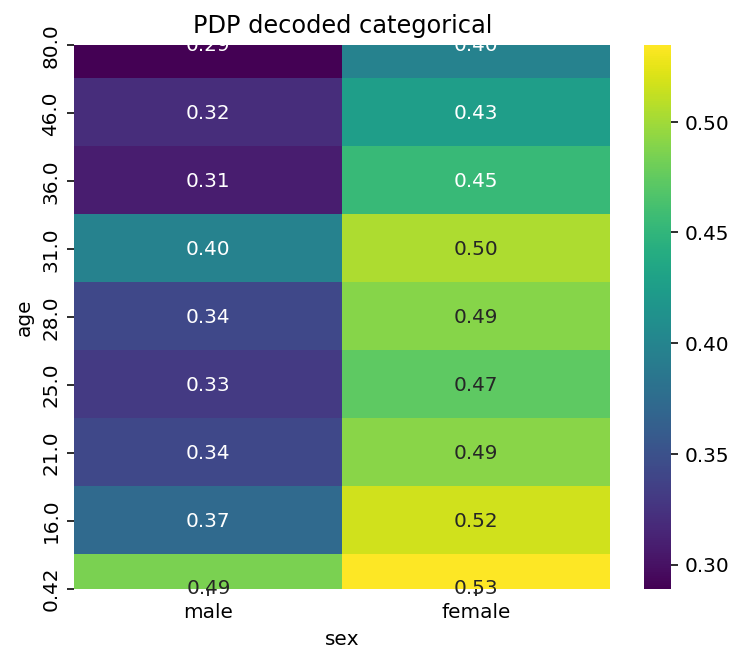

In [66]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(6,5))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP decoded categorical');

In [67]:
import numpy as np
import pandas as pd

# 킹카운티 주택가격 데이터셋을 사용하겠습니다
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/kc_house_data/kc_house_data.csv')

# price, longitude, latitude 양 끝단 값 1% 제거합니다.
# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['long'] >= np.percentile(df['long'], 0.05)) & 
        (df['long'] <= np.percentile(df['long'], 99.95)) &
        (df['lat'] >= np.percentile(df['lat'], 0.05)) & 
        (df['lat'] < np.percentile(df['lat'], 99.95))]

# split train/test, 2015-03-01 기준으로 나눕니다
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2015-03-01')
train = df[df['date'] < cutoff]
test  = df[df['date'] >= cutoff]

In [68]:
features = ['bedrooms', 'bathrooms', 'long', 'lat']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [69]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [70]:
print('최적 하이퍼파라미터: ', search.best_params_)
print('CV MAE: ', -search.best_score_)
model = search.best_estimator_

최적 하이퍼파라미터:  {'max_depth': 15, 'max_features': 0.6327377306009369, 'n_estimators': 166}
CV MAE:  101224.42224844794
